In [1]:
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import matplotlib.pyplot as plt
import numpy as np
import math
import nltk

In [25]:
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',#put your password for mysql server here.
                             db='yelp_db',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

raw_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  GROUP_CONCAT(category.category SEPARATOR ', ') AS categories
  FROM category
  inner join business on
  business.id = category.business_id
  where business.city ="Pittsburgh"
  GROUP BY business.id
  HAVING categories LIKE "%Restaurants%"''',connection) #.values

In [27]:
from sklearn.cluster import KMeans
features = ['latitude', 'longitude']
pitts_cuisines = raw_data[features]
kmeans = KMeans(n_clusters=100, random_state=0).fit(pitts_cuisines)

In [28]:
# optimal number of clusters
from sklearn.metrics import silhouette_score
silhouette_score(pitts_cuisines, kmeans.labels_)

0.55829162868149362

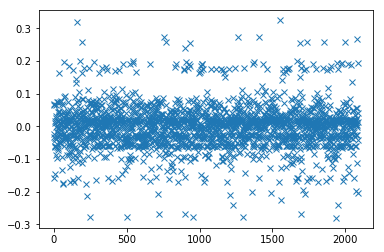

In [30]:
# visualize the clusers
from sklearn import decomposition
pca = decomposition.PCA(n_components=1)
pca.fit(pitts_cuisines)
X = pca.transform(pitts_cuisines)
X.flatten()

import matplotlib.pyplot as plt
plt.plot(X.flatten(), 'x')
plt.show()